In [1]:
# data cleaning
import numpy as np
import pandas as pd

# feature engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

# model
from xgboost import XGBRegressor

# error score
from sklearn.model_selection import cross_val_score

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
data = pd.read_csv(r'train.csv', index_col='Id')
data_test = pd.read_csv(r'test.csv', index_col='Id')

In [3]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Missing Values - Train Data

In [5]:
# missing data
total_missing = data.isnull().sum().sort_values(ascending=False)
percent_missing = (data.isnull().sum() / data.isnull().count())*100
missing_data = pd.concat([total_missing, percent_missing], axis=1,
                         keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


#### Droping data columns with 15% missing value

In [6]:
data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 
                  'Fence', 'FireplaceQu', 'LotFrontage'], 
                 axis=1)
data.shape

(1460, 74)

We going to write a function To find missing values in each columns

In [7]:
# missing values - function
def missing_values(data, n):
    total_missing = data.isnull().sum().sort_values(ascending=False)
    percent_missing = (data.isnull().sum() / data.isnull().count())*100
    missing_data = pd.concat([total_missing, percent_missing], axis=1,
                            keys=['Total', 'Percent'])
    return missing_data.head(n)

In [8]:
# missing data
missing_values(data, 14)

,Total,Percent
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtFinType1,37,2.534247


#### Column - GarageType
NA - No Garage

so we can replace NA with No Garage

In [9]:
data.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [10]:
data.GarageType = data.GarageType.fillna('No Garage')
missing_values(data, 13)

,Total,Percent
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrArea,8,0.547945


#### Column - GarageYrBlt

In [11]:
data.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [12]:
# finding index of missing values
idx = data[data['GarageYrBlt'].isnull()].index.tolist()
data.iloc[idx].head(6)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
41,20,RL,8658,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,12,2006,WD,Abnorml,160000
50,20,RL,7742,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,0,0,0,0,0,1,2007,WD,Normal,127000
80,50,RM,10440,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,...,128,0,0,0,0,5,2009,WD,Normal,110000
90,20,RL,8070,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,8,2007,WD,Normal,123600
91,20,RL,7200,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,7,2006,WD,Normal,109900
101,20,RL,10603,Pave,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,0,2,2010,WD,Normal,205000


Filling missing values in GarageYrBlt column

In [13]:
data.GarageYrBlt = data.GarageYrBlt.fillna(method='bfill',
                                           axis=0)
missing_values(data, 12)

,Total,Percent
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945


#### Column - GarageFinish
NA - No Garage

so we can replace NA with No Garage

In [14]:
data.GarageFinish.unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [15]:
data.GarageFinish = data.GarageFinish.fillna('No Garage')
missing_values(data, 11)

,Total,Percent
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtCond,37,2.534247
BsmtQual,37,2.534247
BsmtFinType1,37,2.534247
MasVnrArea,8,0.547945
MasVnrType,8,0.547945
Electrical,1,0.068493


#### Column - GarageQual
NA - No Garage

so we can replace NA with No Garage

In [16]:
data.GarageQual.unique()

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

In [17]:
data.GarageQual = data.GarageQual.fillna('No Garage')
missing_values(data, 10)

,Total,Percent
GarageCond,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtFinType1,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
Functional,0,0.000000


#### Column - GarageCond
NA - No Garage

so we can replace NA with No Garage

In [18]:
data.GarageCond = data.GarageCond.fillna('No Garage')
missing_values(data, 9)

,Total,Percent
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
Functional,0,0.000000


#### Column - BsmtFinType2
NA - No Basement

so we can replace NA with No Basement

In [19]:
data.BsmtFinType2.unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [20]:
data.BsmtFinType2 = data.BsmtFinType2.fillna('No Basement')
missing_values(data, 8)

,Total,Percent
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
HalfBath,0,0.000000


#### Column - BsmtExposure
NA - No Basement

so we can replace NA with No Basement

In [21]:
data.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [22]:
data.BsmtExposure = data.BsmtExposure.fillna('No Basement')
missing_values(data, 7)

,Total,Percent
BsmtFinType1,37,2.534247
BsmtCond,37,2.534247
BsmtQual,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
BsmtHalfBath,0,0.000000


#### Column - BsmtFinType1
NA - No Basement

so we can replace NA with No Basement

In [23]:
data.BsmtFinType1.unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [24]:
data.BsmtFinType1 = data.BsmtFinType1.fillna('No Basement')
missing_values(data, 6)

,Total,Percent
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
GarageType,0,0.000000


#### Column - BsmtQual
NA - No Basement

so we can replace NA with No Basement

In [25]:
data.BsmtQual.unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [26]:
data.BsmtQual = data.BsmtQual.fillna('No Basement')
missing_values(data, 5)

,Total,Percent
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
MSSubClass,0,0.000000


#### Column - BsmtCond
NA - No Basement

So we can replace NA with No Basement

In [27]:
data.BsmtCond.unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [28]:
data.BsmtCond = data.BsmtCond.fillna('No Basement')
missing_values(data, 4)

,Total,Percent
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
BedroomAbvGr,0,0.000000


#### Column - MasVnrType
Cinder Block **NOT** found in the data set

So  we assuming that missing values are Cinder Blockes

In [29]:
data.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [30]:
data.MasVnrType = data.MasVnrType.fillna('CBlock')
missing_values(data, 3)

,Total,Percent
MasVnrArea,8,0.547945
Electrical,1,0.068493
GarageYrBlt,0,0.000000


#### Column - MasVnrArea
missing values filling by using **back-fill** method

In [31]:
data.MasVnrArea.unique()

array([1.960e+02, 0.000e+00, 1.620e+02, 3.500e+02, 1.860e+02, 2.400e+02,
       2.860e+02, 3.060e+02, 2.120e+02, 1.800e+02, 3.800e+02, 2.810e+02,
       6.400e+02, 2.000e+02, 2.460e+02, 1.320e+02, 6.500e+02, 1.010e+02,
       4.120e+02, 2.720e+02, 4.560e+02, 1.031e+03, 1.780e+02, 5.730e+02,
       3.440e+02, 2.870e+02, 1.670e+02, 1.115e+03, 4.000e+01, 1.040e+02,
       5.760e+02, 4.430e+02, 4.680e+02, 6.600e+01, 2.200e+01, 2.840e+02,
       7.600e+01, 2.030e+02, 6.800e+01, 1.830e+02, 4.800e+01, 2.800e+01,
       3.360e+02, 6.000e+02, 7.680e+02, 4.800e+02, 2.200e+02, 1.840e+02,
       1.129e+03, 1.160e+02, 1.350e+02, 2.660e+02, 8.500e+01, 3.090e+02,
       1.360e+02, 2.880e+02, 7.000e+01, 3.200e+02, 5.000e+01, 1.200e+02,
       4.360e+02, 2.520e+02, 8.400e+01, 6.640e+02, 2.260e+02, 3.000e+02,
       6.530e+02, 1.120e+02, 4.910e+02, 2.680e+02, 7.480e+02, 9.800e+01,
       2.750e+02, 1.380e+02, 2.050e+02, 2.620e+02, 1.280e+02, 2.600e+02,
       1.530e+02, 6.400e+01, 3.120e+02, 1.600e+01, 

In [32]:
data.MasVnrArea = data.MasVnrArea.fillna(method='bfill',
                                         axis=0)
missing_values(data, 2)

,Total,Percent
Electrical,1,0.068493
MSSubClass,0,0.000000


#### Column - Electrical
Missing value filling by using **back-fill** method

In [33]:
data.Electrical.unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [34]:
data.Electrical = data.Electrical.fillna(method='bfill',
                                        axis=0)
missing_values(data, 2)

,Total,Percent
MSSubClass,0,0.0
GarageYrBlt,0,0.0


### Missing Values - Test Data

In [35]:
missing_values(data_test, 34)

,Total,Percent
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageQual,78,5.346127
GarageCond,78,5.346127


##### Droping columns with >15% missing values

In [36]:
data_test = data_test.drop(['PoolQC', 'MiscFeature', 'Alley', 
                  'Fence', 'FireplaceQu', 'LotFrontage'], 
                 axis=1)
data.shape

(1460, 74)

In [37]:
# missing data
missing_values(data_test, 28)

,Total,Percent
GarageQual,78,5.346127
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageCond,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684


#### Column - GarageQual
NA - No Garage

So we can replace NA with No Garage

In [38]:
data_test.GarageQual.unique()

array(['TA', nan, 'Fa', 'Gd', 'Po'], dtype=object)

In [39]:
data_test.GarageQual = data_test.GarageQual.fillna('No Garage')
missing_values(data_test, 27)

,Total,Percent
GarageCond,78,5.346127
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642


#### Column - GarageCond
NA - No Garage

So we can replace NA with No Garage

In [40]:
data_test.GarageCond.unique()

array(['TA', nan, 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

In [41]:
data_test.GarageCond = data_test.GarageCond.fillna('No Garage')
missing_values(data_test, 26)

,Total,Percent
GarageFinish,78,5.346127
GarageYrBlt,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101


#### Column - GarageFinish
NA - No Garage

So we can replace NA with No Garage

In [42]:
data_test.GarageFinish.unique()

array(['Unf', 'Fin', 'RFn', nan], dtype=object)

In [43]:
data_test.GarageFinish = data_test.GarageFinish.fillna('No Garage')
missing_values(data_test, 25)

,Total,Percent
GarageYrBlt,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160


#### Column - GarageYrBlt
Replace missing values by **back-fill** method

In [44]:
data_test.GarageYrBlt.unique()

array([1961., 1958., 1997., 1998., 1992., 1993., 1990., 1970., 1999.,
       1971., 1975., 2009., 2005., 2003., 2002., 2006., 2004., 1920.,
       1974., 2000., 2010., 1967., 1978., 1966., 1964.,   nan, 1994.,
       1949., 1959., 1956., 1952., 1955., 1989., 1950., 1960., 1963.,
       1900., 1957., 1938., 1948., 1962., 1928., 1930., 1926., 1939.,
       1973., 1942., 1979., 1923., 1915., 1917., 1940., 1910., 1969.,
       1968., 1977., 1945., 1987., 1947., 1954., 1941., 1951., 1896.,
       1976., 2008., 2007., 1965., 2001., 1972., 1984., 1985., 1996.,
       1995., 1980., 1986., 1981., 1982., 1991., 1988., 1953., 1924.,
       1927., 1946., 1934., 1983., 1916., 1918., 1937., 1932., 1935.,
       1925., 1921., 1895., 1922., 2207., 1936., 1943., 1919.])

In [45]:
data_test.GarageYrBlt = data_test.GarageYrBlt.fillna(method='bfill', axis=0)
missing_values(data_test, 24)

,Total,Percent
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080


#### Column - GarageType
NA - No Garage

So we can replace NA with No Garage

In [46]:
data_test.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', nan, 'Basment', '2Types', 'CarPort'],
      dtype=object)

In [47]:
data_test.GarageType = data_test.GarageType.fillna('No Garage')
missing_values(data_test, 23)

,Total,Percent
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
Functional,2,0.137080


#### Column - BsmtCond
NA - No Basement

So we can replace NA with No Basement

In [48]:
data_test.BsmtCond.unique()

array(['TA', 'Po', 'Fa', 'Gd', nan], dtype=object)

In [49]:
data_test.BsmtCond = data_test.BsmtCond.fillna('No Basement')
missing_values(data_test, 22)

,Total,Percent
BsmtQual,44,3.015764
BsmtExposure,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
Functional,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080


#### Column - BsmtQual
NA - No Basement

So we can replace NA with No Basement

In [50]:
data_test.BsmtQual.unique()

array(['TA', 'Gd', 'Ex', 'Fa', nan], dtype=object)

In [51]:
data_test.BsmtQual = data_test.BsmtQual.fillna('No Basement')
missing_values(data_test, 21)

,Total,Percent
BsmtExposure,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
Functional,2,0.137080
BsmtFullBath,2,0.137080
Utilities,2,0.137080
BsmtHalfBath,2,0.137080


#### Column - BsmtExposure
NA - No Basement

So we can replace NA with No Basement

In [52]:
data_test.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [53]:
data_test.BsmtExposure = data_test.BsmtExposure.fillna('No Basement')
missing_values(data_test, 20)

,Total,Percent
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080
Functional,2,0.137080
GarageCars,1,0.068540


#### Column - BsmtFinType2
NA - No Basement

So we can replace NA with No Basement

In [54]:
data_test.BsmtFinType2.unique()

array(['LwQ', 'Unf', 'Rec', 'BLQ', 'GLQ', 'ALQ', nan], dtype=object)

In [55]:
data_test.BsmtFinType2 = data_test.BsmtFinType2.fillna('No Basement')
missing_values(data_test, 19)

,Total,Percent
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Functional,2,0.137080
Utilities,2,0.137080
BsmtFinSF1,1,0.068540
Exterior1st,1,0.068540


#### Column - BsmtFinType1
NA - No Basement

So we can replace NA with No Basement

In [56]:
data_test.BsmtFinType1.unique()

array(['Rec', 'ALQ', 'GLQ', 'Unf', 'BLQ', 'LwQ', nan], dtype=object)

In [57]:
data_test.BsmtFinType1 = data_test.BsmtFinType1.fillna('No Basement')
missing_values(data_test, 18)

,Total,Percent
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080
Functional,2,0.137080
KitchenQual,1,0.068540
Exterior2nd,1,0.068540
GarageCars,1,0.068540


#### Column - MasVnrType
Cinder Block NOT found in the data set

So we assuming that missing values are Cinder Blockes

In [58]:
data_test.MasVnrType.unique()

array(['None', 'BrkFace', 'Stone', 'BrkCmn', nan], dtype=object)

In [59]:
data_test.MasVnrType = data_test.MasVnrType.fillna('CBlock')
missing_values(data_test, 17)

,Total,Percent
MasVnrArea,15,1.028101
MSZoning,4,0.274160
Functional,2,0.137080
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080
Exterior1st,1,0.068540
BsmtFinSF2,1,0.068540
KitchenQual,1,0.068540
BsmtFinSF1,1,0.068540


#### Column - MasVnrArea
Filling missing values with **back-fill** method

In [60]:
data_test.MasVnrArea.unique()

array([0.000e+00, 1.080e+02, 2.000e+01, 5.040e+02, 4.920e+02, 1.620e+02,
       2.560e+02, 6.150e+02, 2.400e+02, 1.095e+03, 2.320e+02, 1.780e+02,
       1.400e+01, 1.140e+02, 2.260e+02, 1.220e+02, 2.500e+02, 1.800e+02,
       1.200e+02, 2.160e+02, 1.159e+03, 1.720e+02, 2.680e+02, 1.440e+02,
       2.650e+02, 3.400e+02, 5.060e+02, 1.500e+02, 9.100e+01, 4.320e+02,
       2.180e+02, 7.710e+02, 3.000e+02, 9.000e+01, 7.200e+01, 4.700e+01,
       2.880e+02, 9.600e+01, 1.770e+02, 8.500e+01, 8.000e+01, 3.200e+02,
       1.700e+02, 2.030e+02, 3.710e+02, 4.300e+02, 4.400e+01, 1.860e+02,
       6.000e+01, 4.400e+02, 1.880e+02, 3.200e+01, 4.500e+01, 1.570e+02,
       1.010e+02, 2.290e+02, 1.610e+02, 1.960e+02, 4.250e+02, 1.650e+02,
       7.260e+02, 4.500e+02, 4.720e+02, 3.020e+02, 2.380e+02, 2.840e+02,
       2.850e+02, 4.180e+02, 7.240e+02, 3.830e+02, 1.350e+02, 1.760e+02,
       7.300e+02, 4.700e+02, 3.080e+02, 5.000e+02, 2.700e+02, 1.630e+02,
       1.600e+01, 2.000e+02,       nan, 2.100e+02, 

In [61]:
data_test.MasVnrArea = data_test.MasVnrArea.fillna(method='bfill',
                                                   axis=0)
missing_values(data_test, 16)

,Total,Percent
MSZoning,4,0.27416
BsmtHalfBath,2,0.13708
Functional,2,0.13708
BsmtFullBath,2,0.13708
Utilities,2,0.13708
Exterior1st,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854


#### Column - MSZoning
Filling missing values with **back-fill** method

In [62]:
data_test.MSZoning.unique()

array(['RH', 'RL', 'RM', 'FV', 'C (all)', nan], dtype=object)

In [63]:
data_test.MSZoning = data_test.MSZoning.fillna(method='bfill',
                                              axis=0)
missing_values(data_test, 15)

,Total,Percent
Functional,2,0.13708
BsmtFullBath,2,0.13708
Utilities,2,0.13708
BsmtHalfBath,2,0.13708
Exterior1st,1,0.06854
BsmtFinSF2,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854


#### Column - Functional
Salvage only missing from list, so lets assuming that missing values is Salvage only

In [64]:
data_test.Functional.unique()

array(['Typ', 'Min2', 'Min1', 'Mod', 'Maj1', 'Sev', 'Maj2', nan],
      dtype=object)

In [65]:
data_test.Functional = data_test.Functional.fillna('Sal')
missing_values(data_test, 14)

,Total,Percent
BsmtFullBath,2,0.13708
Utilities,2,0.13708
BsmtHalfBath,2,0.13708
Exterior1st,1,0.06854
BsmtFinSF2,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
BsmtUnfSF,1,0.06854


#### Column - BsmtFullBath
Missing values filling by using **back-fill** method

In [66]:
data_test.BsmtFullBath.unique()

array([ 0.,  1.,  2.,  3., nan])

In [67]:
data_test.BsmtFullBath = data_test.BsmtFullBath.fillna(method='bfill',
                                                      axis=0)
missing_values(data_test, 13)

,Total,Percent
BsmtHalfBath,2,0.13708
Utilities,2,0.13708
Exterior1st,1,0.06854
BsmtUnfSF,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
TotalBsmtSF,1,0.06854


#### Column - BsmtHalfBath
Missing values filling by using **back-fill** method

In [68]:
data_test.BsmtHalfBath.unique()

array([ 0.,  1., nan,  2.])

In [69]:
data_test.BsmtHalfBath = data_test.BsmtHalfBath.fillna(method='bfill',
                                                      axis=0)
missing_values(data_test, 12)

,Total,Percent
Utilities,2,0.13708
Exterior1st,1,0.06854
BsmtUnfSF,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
TotalBsmtSF,1,0.06854
SaleType,1,0.06854


#### Column - Utilities
Missing values filling by using **back-fill** method

In [70]:
data_test.Utilities.unique()

array(['AllPub', nan], dtype=object)

In [71]:
data_test.Utilities = data_test.Utilities.fillna(method='bfill',
                                                axis=0)
missing_values(data_test, 11)

,Total,Percent
Exterior2nd,1,0.06854
SaleType,1,0.06854
Exterior1st,1,0.06854
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854


#### Column - Exterior2nd
Other is **NOT** in the list, so we assuming that Other is the missing value

In [72]:
data_test.Exterior2nd.unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'Brk Cmn',
       'CmentBd', 'ImStucc', 'Wd Shng', 'AsbShng', 'Stucco', 'CBlock',
       'BrkFace', 'AsphShn', nan, 'Stone'], dtype=object)

In [73]:
data.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [74]:
data_test.Exterior2nd = data_test.Exterior2nd.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 10)

,Total,Percent
Exterior1st,1,0.06854
SaleType,1,0.06854
KitchenQual,1,0.06854
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
HalfBath,0,0.00000


#### Column - Exterior1st
Missing value filling by using **back-fill** method

In [75]:
data_test.Exterior1st.unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
       'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn',
       nan, 'CBlock'], dtype=object)

In [76]:
data_test.Exterior1st = data_test.Exterior1st.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 9)

,Total,Percent
SaleType,1,0.06854
KitchenQual,1,0.06854
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - SaleType
Missing value filling by using **back-fill** method

In [77]:
data_test.SaleType.unique()

array(['WD', 'COD', 'New', 'ConLD', 'Oth', 'Con', 'ConLw', 'ConLI', 'CWD',
       nan], dtype=object)

In [78]:
data_test.SaleType = data_test.SaleType.fillna(method='bfill',
                                              axis=0)
missing_values(data_test, 8)

,Total,Percent
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
KitchenQual,1,0.06854
BsmtFinSF1,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - TotalBsmtSF
Missing values filling by using **back-fill** method

In [79]:
data_test.TotalBsmtSF.unique()

array([ 882., 1329.,  928.,  926., 1280.,  763., 1168.,  789., 1300.,
       1405.,  483.,  525.,  855.,  836., 1590., 1544., 1698., 1822.,
       2846., 1671., 1370., 1324., 1145.,  384.,  847., 1629., 1595.,
       1218., 1468.,  831.,  816., 1208., 1231., 1390., 1488.,  840.,
        600.,  756.,  530., 1642.,  975., 1492., 1829., 1224.,  715.,
       1232., 1209., 1510.,  533., 1728., 1140.,  782., 1080., 1604.,
       1480., 1143., 1206., 1244.,  832.,  864.,  972.,  988.,  576.,
       1175., 1395.,  709.,  936., 1347.,  827., 1027., 1008.,  678.,
        930.,  346.,  738., 1108.,  765.,  608.,  572.,  835.,  780.,
        528., 1124.,  888.,  662., 1422.,  689., 1212.,  707.,  856.,
       1832., 1319.,  720., 1420.,  660., 1117.,  663., 1172., 1508.,
       1250., 1433.,  946., 1222.,  676.,  870.,  878., 1026.,  876.,
       1978., 1040.,  848.,    0.,  381., 1196.,  744.,  960., 1107.,
        894., 1528., 1032.,  423.,  982., 1191.,  480.,  629., 1594.,
       1049., 1243.,

In [80]:
data_test.TotalBsmtSF = data_test.TotalBsmtSF.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 7)

,Total,Percent
KitchenQual,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
GarageCars,1,0.06854
BsmtFinSF1,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - KitchenQual
Missing value filling by using **back-fill** method

In [81]:
data_test.KitchenQual.unique()

array(['TA', 'Gd', 'Ex', 'Fa', nan], dtype=object)

In [82]:
data_test.KitchenQual = data_test.KitchenQual.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 6)

,Total,Percent
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
GarageCars,1,0.06854
BsmtFinSF1,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - BsmtUnfSF
Missing values filling by using **back-fill** method

In [83]:
data_test.BsmtUnfSF.unique()

array([ 270.,  406.,  137.,  324., 1017.,  763.,  233.,  789.,  663.,
          0.,  354.,  327.,  225.,  341.,  836., 1590., 1544., 1588.,
       1794., 1473., 1093., 1346., 1324., 1129.,   58.,  847., 1629.,
       1595., 1218.,   54.,  831.,  816.,  223.,  261.,  190.,  840.,
        320.,  224.,  290.,  286.,  610.,  491.,  659., 1323.,  143.,
        386.,  534.,  150.,  500.,  533.,  228.,  470.,  482.,  136.,
       1604.,  292.,  125.,  510.,  832.,  525.,  456.,  576.,  161.,
        237.,  415.,  661.,  357.,  827.,  247.,  678.,  930.,  346.,
        455.,  200.,  634.,  577.,  144.,  308.,  316.,  480.,  252.,
        164.,  888.,  780.,  662.,  656.,  689.,  186.,  232.,  120.,
       1128.,   89.,  328.,  660.,  153.,  172.,  564.,  218.,  162.,
       1250.,   86., 1198.,  676.,  140.,  396.,  296., 1040.,  176.,
        381.,  126.,  744.,  960.,  974.,  618.,  894.,  850.,  657.,
         80.,  235., 1115.,  321.,  756.,  221.,  434., 1958., 1258.,
       1214.,  384.,

In [84]:
data_test.BsmtUnfSF = data_test.BsmtUnfSF.fillna(method='bfill',
                                                axis=0)
missing_values(data_test, 5)

,Total,Percent
GarageCars,1,0.06854
BsmtFinSF2,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - GarageCars
Missing values filling by using **back-fill** method

In [85]:
data_test.GarageCars.unique()

array([ 1.,  2.,  3.,  0.,  4.,  5., nan])

In [86]:
data_test.GarageCars = data_test.GarageCars.fillna(method='bfill',
                                                  axis=0)
missing_values(data_test, 4)

,Total,Percent
BsmtFinSF2,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - BsmtFinSF2
Missing values filling by using **back-fill** method

In [87]:
data_test.BsmtFinSF2.unique()

array([ 144.,    0.,   78.,  859.,  981.,   42.,   46.,  162.,  174.,
        350.,  263., 1073.,   12.,  159.,  474.,  453.,  684.,  387.,
        688.,  252.,  590.,  284.,  276.,  168.,  294.,  622.,  113.,
       1526.,  360.,  774.,  364.,  596.,  884.,   92.,  216.,  136.,
        147.,  201.,  512.,  247.,  202.,  483.,  750.,   60.,  102.,
         95.,   63.,  262.,  393.,  286.,  450.,   72.,  243.,  694.,
        875.,  507.,  435.,  419.,  250.,  116.,  624.,   76.,  270.,
        110.,  288.,  186.,  449.,   48.,  613.,  495.,  852.,  555.,
        799.,  811.,  842.,  670.,  382.,  456.,  308.,   52.,  196.,
        128.,  488.,  319.,  273.,   nan,  240.,  956.,  723.,  120.,
        679.,   40.,  121.,  604.,  153.,  619.,    6.,  351., 1037.,
        829.,  264.,   38.,  206.,  167.,  543.,  259.,  404.,  138.,
        955.,  691.,  354.,   66.,  154.,  442.,  448.,  210.,  227.,
        398.,  127.,  722.,  761.,  529.,  522.,  873.,  891.,  755.,
        321.,  915.,

In [88]:
data_test.BsmtFinSF2 = data_test.BsmtFinSF2.fillna(method='bfill',
                                                   axis=0)
missing_values(data_test, 3)

,Total,Percent
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - GarageArea
Missing values filling by using **back-fill** method

In [89]:
data_test.GarageArea.unique()

array([ 730.,  312.,  482.,  470.,  506.,  440.,  420.,  393.,  525.,
        511.,  264.,  320.,  308.,  751.,  868.,  678.,  958.,  756.,
        484.,  430.,  437.,  400.,  433.,  962.,  880.,  676.,  528.,
        429.,  461.,  762.,  713.,  588.,  480.,  496.,  852.,  592.,
        596.,  535.,  660.,  441.,  490.,  504.,  517.,    0.,  315.,
        576.,  620.,  263.,  318.,  305.,  280.,  240.,  551.,  780.,
        288.,  624.,  363.,  200.,  572.,  180.,  365.,  231.,  450.,
        416.,  591.,  690.,  522.,  467.,  209.,  366., 1017.,  615.,
        580.,  513.,  850.,  621.,  319.,  336.,  352.,  260.,  399.,
        473.,  598.,  531.,  625.,  330.,  741.,  776.,  520.,  686.,
        253.,  286.,  495.,  616.,  275.,  502.,  632.,  390.,  564.,
        396.,  409.,  567.,  529.,  479.,  581.,  565.,  478.,  477.,
        345.,  656.,  754.,  864.,  896.,  834.,  932.,  640.,  927.,
        700.,  583.,  886.,  871.,  949.,  685.,  649.,  539.,  701.,
        392.,  397.,

In [90]:
data_test.GarageArea = data_test.GarageArea.fillna(method='bfill',
                                                  axis=0)
missing_values(data_test, 2)

,Total,Percent
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - BsmtFinSF1
Missing values filling by using **back-fill** method

In [91]:
data_test.BsmtFinSF1.unique()

array([ 468.,  923.,  791.,  602.,  263.,    0.,  935.,  637.,  804.,
       1051.,  156.,  300.,  514.,  110.,   28., 1373.,  578.,   24.,
         16.,  326., 1414.,  126.,  250., 1129., 1298.,  280.,  368.,
        376.,  466.,  244., 1032.,  484.,  833.,  506., 1137.,  687.,
        329.,  698., 1059., 1010., 1500.,  670.,  944., 1188.,  856.,
        936.,  734.,  339.,  648.,  532.,  481.,  588.,  717.,   48.,
        579.,  274.,  780.,  176.,  283.,  788.,  474.,  188.,  452.,
        264.,  360.,  276.,  448.,  960.,  766., 1026.,   73.,  736.,
        704.,  240.,  775., 1319.,  267., 1092.,  964.,  288.,  104.,
        192.,  954., 1346., 1433.,  860.,  870.,  353.,  198.,  480.,
       1682.,  672., 1070.,  528.,  133.,  238.,  426.,  375.,  343.,
        747.,   76.,  308.,  615.,  679.,   78.,   42.,  915.,  294.,
        469.,  207.,  458.,  476., 1341.,  564.,  844.,  847.,  850.,
        284., 1965.,  341.,  741.,  189.,  600.,  400.,  363.,  832.,
        622.,  225.,

In [92]:
data_test.BsmtFinSF1 = data_test.BsmtFinSF1.fillna(method='bfill',
                                                  axis=0)
missing_values(data_test, 2)

,Total,Percent
MSSubClass,0,0.0
HeatingQC,0,0.0


**Find the Score of DataSet**

In [93]:
# function
def score_dataset(x, y, model=XGBRegressor()):
    # label encoding for categoricals
    for colname in x.select_dtypes(['object', 'category']):
        x[colname], _ = x[colname].factorize()
        # RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(model, x, y,
                               cv=5,
                               scoring='neg_mean_squared_log_error')
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

##### Find Score of DataSet after Data Cleaning

In [94]:
# assigning variables
x = data.copy()
y = x.pop('SalePrice')

In [95]:
# score
score_dataset(x, y)

0.14464331538070868

## Feature Engeneering
### 1. Mutual Information

In [96]:
# assigning variables
x = data.copy()
y = x.pop('SalePrice')

In [97]:
# label encoding for categoricals
for colname in x.select_dtypes('object'):
    x[colname], _ = x[colname].factorize()

# all discrete features should now have integer dtypes (double-check this before using MI)
discrete_features = x.dtypes == int

##### Function to find MI Score of DataSet

In [98]:
def make_mi_score(x, y, discrete_features):
    mi_scores = mutual_info_regression(x, y,
                                       discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Score',
                         index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [99]:
# mi_score
mi_scores = make_mi_score(x, y, discrete_features)
mi_scores

OverallQual     5.727248e-01
Neighborhood    5.213603e-01
GarageArea      4.931220e-01
GrLivArea       4.328842e-01
YearBuilt       4.095058e-01
                    ...     
Street          8.310775e-04
Utilities       1.887379e-15
PoolArea        2.220446e-16
MiscVal         0.000000e+00
MoSold          0.000000e+00
Name: MI Score, Length: 73, dtype: float64

In [100]:
# bar plot
def plot_mi_score(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    tickes = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, tickes)
    plt.title('Mutual Information Scores')

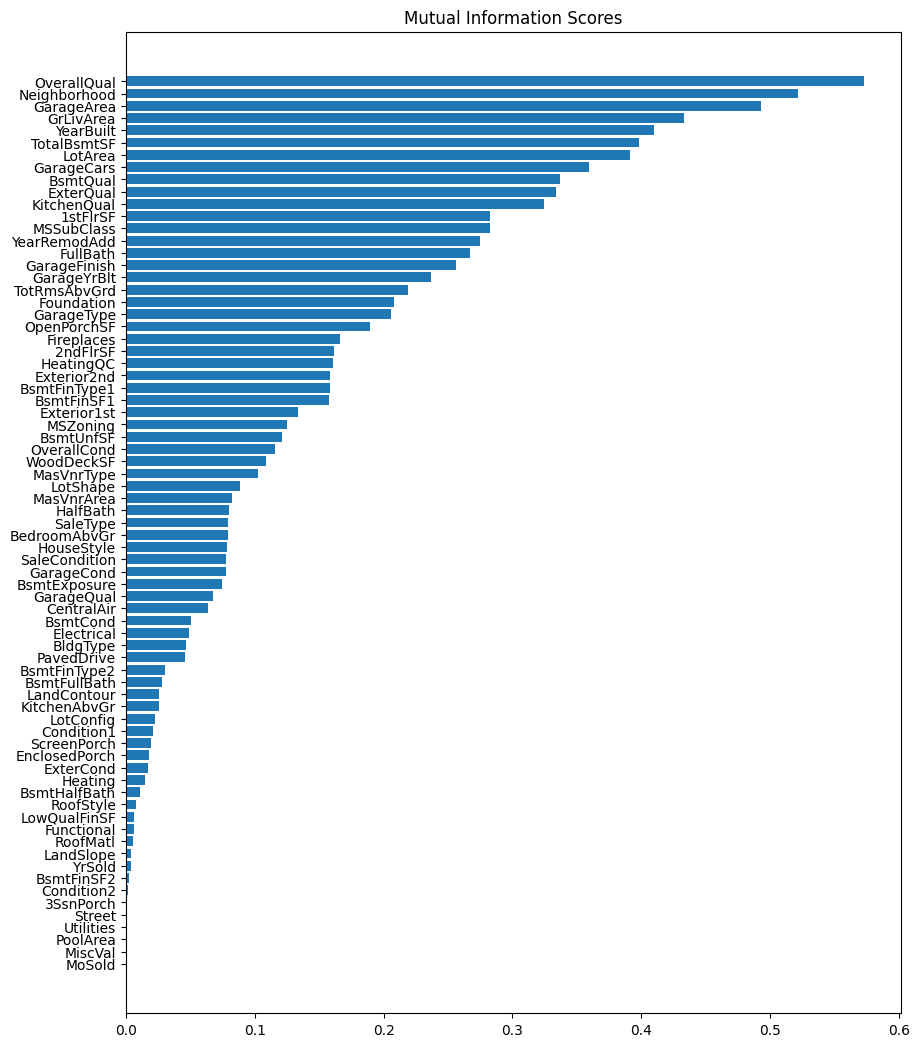

In [101]:
plt.figure(dpi=100, figsize=(10, 13))
plot_mi_score(mi_scores)

##### Remove columns with zero MI Score

In [102]:
data = data.drop(['YrSold', 'MoSold', 'PoolArea',
                 'Utilities', 'Street', 'Condition2',
                 'BsmtFinSF2', '3SsnPorch', 'MiscVal'],
                 axis=1)

In [103]:
x = data.copy()
y = x.pop('SalePrice')

# score
score_dataset(x, y)

0.14137135313135996

When we removed the columns with **MI-Score** zero
The error is get reduced to **0.141371** from **0.144643**

### 2. Clustering
Clusters will break up complicated relationships across features into simpler chunks

#### Clustering columns with high and Low MI Scores:

Columns with **Low MI-Score** maybe not related with **SalePrice**(Target Column). 
But this maybe related with columns with **High MI Score**
So this is help us to find relationship between these columns.  

Creating a Cluster between **OverallQual** and **LowQualFinSF**

In [104]:
features = ['OverallQual', 'LowQualFinSF']

# Standardize
data_x_scaled = data.loc[:, features]
data_x_scaled = (data_x_scaled - data_x_scaled.mean(axis=0)) / data_x_scaled.std(axis=0)

# create cluster feature
kmeans = KMeans(n_clusters=6, random_state=0)
data['Cluster1'] = kmeans.fit_predict(data_x_scaled)
data['Cluster1'] = data['Cluster1'].astype('category')
data.loc[:, features+['Cluster1']].head()

,OverallQual,LowQualFinSF,Cluster1
Id,,,
1,7,0,0
2,6,0,3
3,7,0,0
4,7,0,0
5,8,0,4


In [105]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.14047073751791622

When we cluster between **High-Low** MI-Score columns.
Error get reduced to **0.1404707375** from **0.14137135**

Lets try to visualize this clustering.

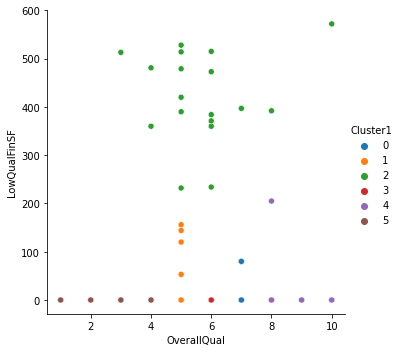

In [106]:
sns.relplot(x='OverallQual', y='LowQualFinSF',
            hue='Cluster1', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster1'>

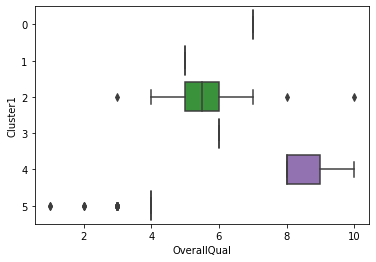

In [107]:
# box plot
sns.boxplot(x='OverallQual', y='Cluster1',
           data=data)

#### Lets write a function for cluster between columns

In [108]:
# Fuction - to create clusters between columns
def cluster_cols(data, col1, col2, n, result_col):
    features = [col1, col2]
    # Standardize
    data_x_scaled = data.loc[:, features]
    data_x_scaled = (data_x_scaled - data_x_scaled.mean(axis=0)) / data_x_scaled.std(axis=0)
    # create cluster feature
    kmeans = KMeans(n_clusters=n, random_state=0)
    data[result_col] = kmeans.fit_predict(data_x_scaled)
    data[result_col] = data[result_col].astype('category')
    return data.loc[:, features+[result_col]].head()

##### Cluster between OverallQual and KitchenAbvGr

In [109]:
cluster_cols(data, 'OverallQual', 'KitchenAbvGr', 8, 'Cluster2')

,OverallQual,KitchenAbvGr,Cluster2
Id,,,
1,7,1,0
2,6,1,3
3,7,1,0
4,7,1,0
5,8,1,4


In [110]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13918334427059587

When we cluster between **High-Low** MI-Score columns.
Error get reduced to **0.139183344** from **0.1404707375**

Lets try to visualize this clustering.

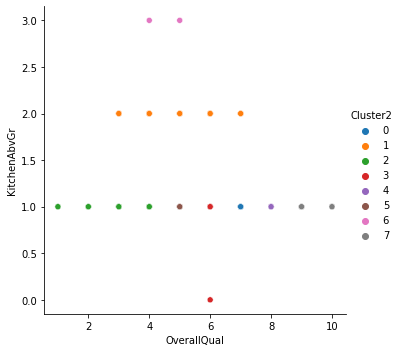

In [111]:
# Visualize this clustering using relational plot
sns.relplot(x='OverallQual', y='KitchenAbvGr',
           hue='Cluster2', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster2'>

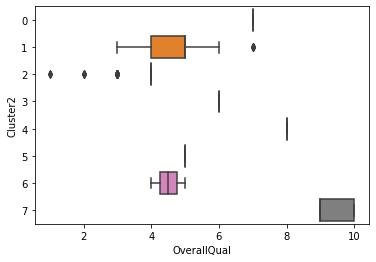

In [112]:
# box-plot
sns.boxplot(x='OverallQual', y='Cluster2',
           data=data)

#### Cluster between OverallQual and HalfBath

In [113]:
cluster_cols(data, 'OverallQual', 'HalfBath', 3, 'Cluster3')

,OverallQual,HalfBath,Cluster3
Id,,,
1,7,1,1
2,6,0,0
3,7,1,1
4,7,0,2
5,8,1,1


In [114]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13818376275530941

When we cluster between **High-Low** MI-Score columns.
Error get reduced to **0.13818376** from **0.139183344**

Lets try to visualize this clustering.

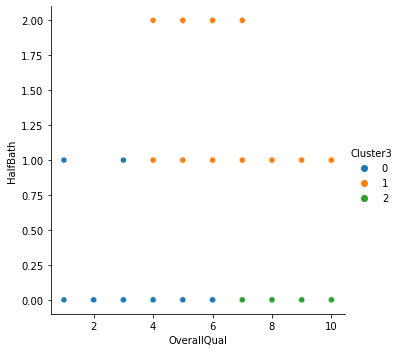

In [115]:
# Visualize this clustering using relational plot
sns.relplot(x='OverallQual', y='HalfBath',
           hue='Cluster3', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster3'>

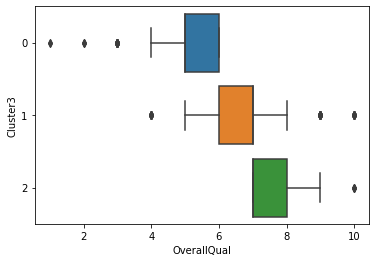

In [116]:
# box-plot
sns.boxplot(x='OverallQual', y='Cluster3',
           data=data)

### Its very difficult to find lowest score of data set by each column

Also categorical columns can't cluster with other columns.

So we going to change all categorical columns to number by using Label Encoding

In [117]:
# make all categorical columns to number, it will help to find heatmap and clusters
data = data.copy()
# label encoding for categoricals
for colname in data.select_dtypes('object'):
    data[colname], _ = data[colname].factorize()

# all discrete features should now have integer dtypes (double-check this before using MI)
discrete_features = data.dtypes == int

In [118]:
# find correlation matrix
data.corr()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice
MSSubClass,1.000000,0.286937,-0.139781,-0.115361,-0.018947,-0.069160,-0.025672,0.181163,-0.034756,0.770840,...,0.090199,0.067069,0.025973,-0.012579,-0.006100,-0.012037,-0.026030,0.012874,-0.015047,-0.084284
MSZoning,0.286937,1.000000,-0.161640,-0.167918,-0.013396,-0.094747,-0.043444,-0.067889,-0.026021,0.271750,...,0.077892,0.063774,0.117402,-0.133311,0.109211,0.075025,-0.067541,0.058948,0.068705,-0.116047
LotArea,-0.139781,-0.161640,1.000000,0.315484,0.258792,0.160976,0.436868,0.043191,0.033795,-0.211111,...,-0.068587,-0.070632,-0.002964,0.171698,0.084774,-0.018340,0.043160,-0.013882,0.000199,0.263843
LotShape,-0.115361,-0.167918,0.315484,1.000000,0.201047,0.308073,0.144248,-0.013295,0.066612,-0.134373,...,-0.094660,-0.101061,-0.100666,0.161717,0.093135,-0.095092,0.065182,0.001435,-0.004773,0.267759
LandContour,-0.018947,-0.013396,0.258792,0.201047,1.000000,0.021107,0.507203,0.113336,-0.021478,-0.042667,...,0.006150,0.001482,0.081031,0.072820,-0.045007,-0.002514,0.003305,-0.014537,0.062826,0.092009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EnclosedPorch,-0.012037,0.075025,-0.018340,-0.095092,-0.002514,0.034085,-0.008843,0.040012,0.040183,-0.116847,...,0.090004,0.092750,0.183532,-0.125989,-0.093079,1.000000,-0.082864,-0.009259,-0.048306,-0.128578
ScreenPorch,-0.026030,-0.067541,0.043160,0.065182,0.003305,0.010340,0.052976,0.006352,0.023758,-0.041426,...,-0.037706,-0.070077,-0.037535,-0.074181,0.074304,-0.082864,1.000000,-0.029731,-0.028190,0.111447
SaleType,0.012874,0.058948,-0.013882,0.001435,-0.014537,0.012120,-0.056680,0.008466,0.003128,0.044289,...,0.029403,0.024100,-0.021553,-0.023842,0.011643,-0.009259,-0.029731,1.000000,0.232149,0.072896
SaleCondition,-0.015047,0.068705,0.000199,-0.004773,0.062826,-0.013638,0.017187,0.007101,-0.019800,0.040365,...,0.003890,0.000375,-0.049674,-0.017134,0.064042,-0.048306,-0.028190,0.232149,1.000000,0.142503


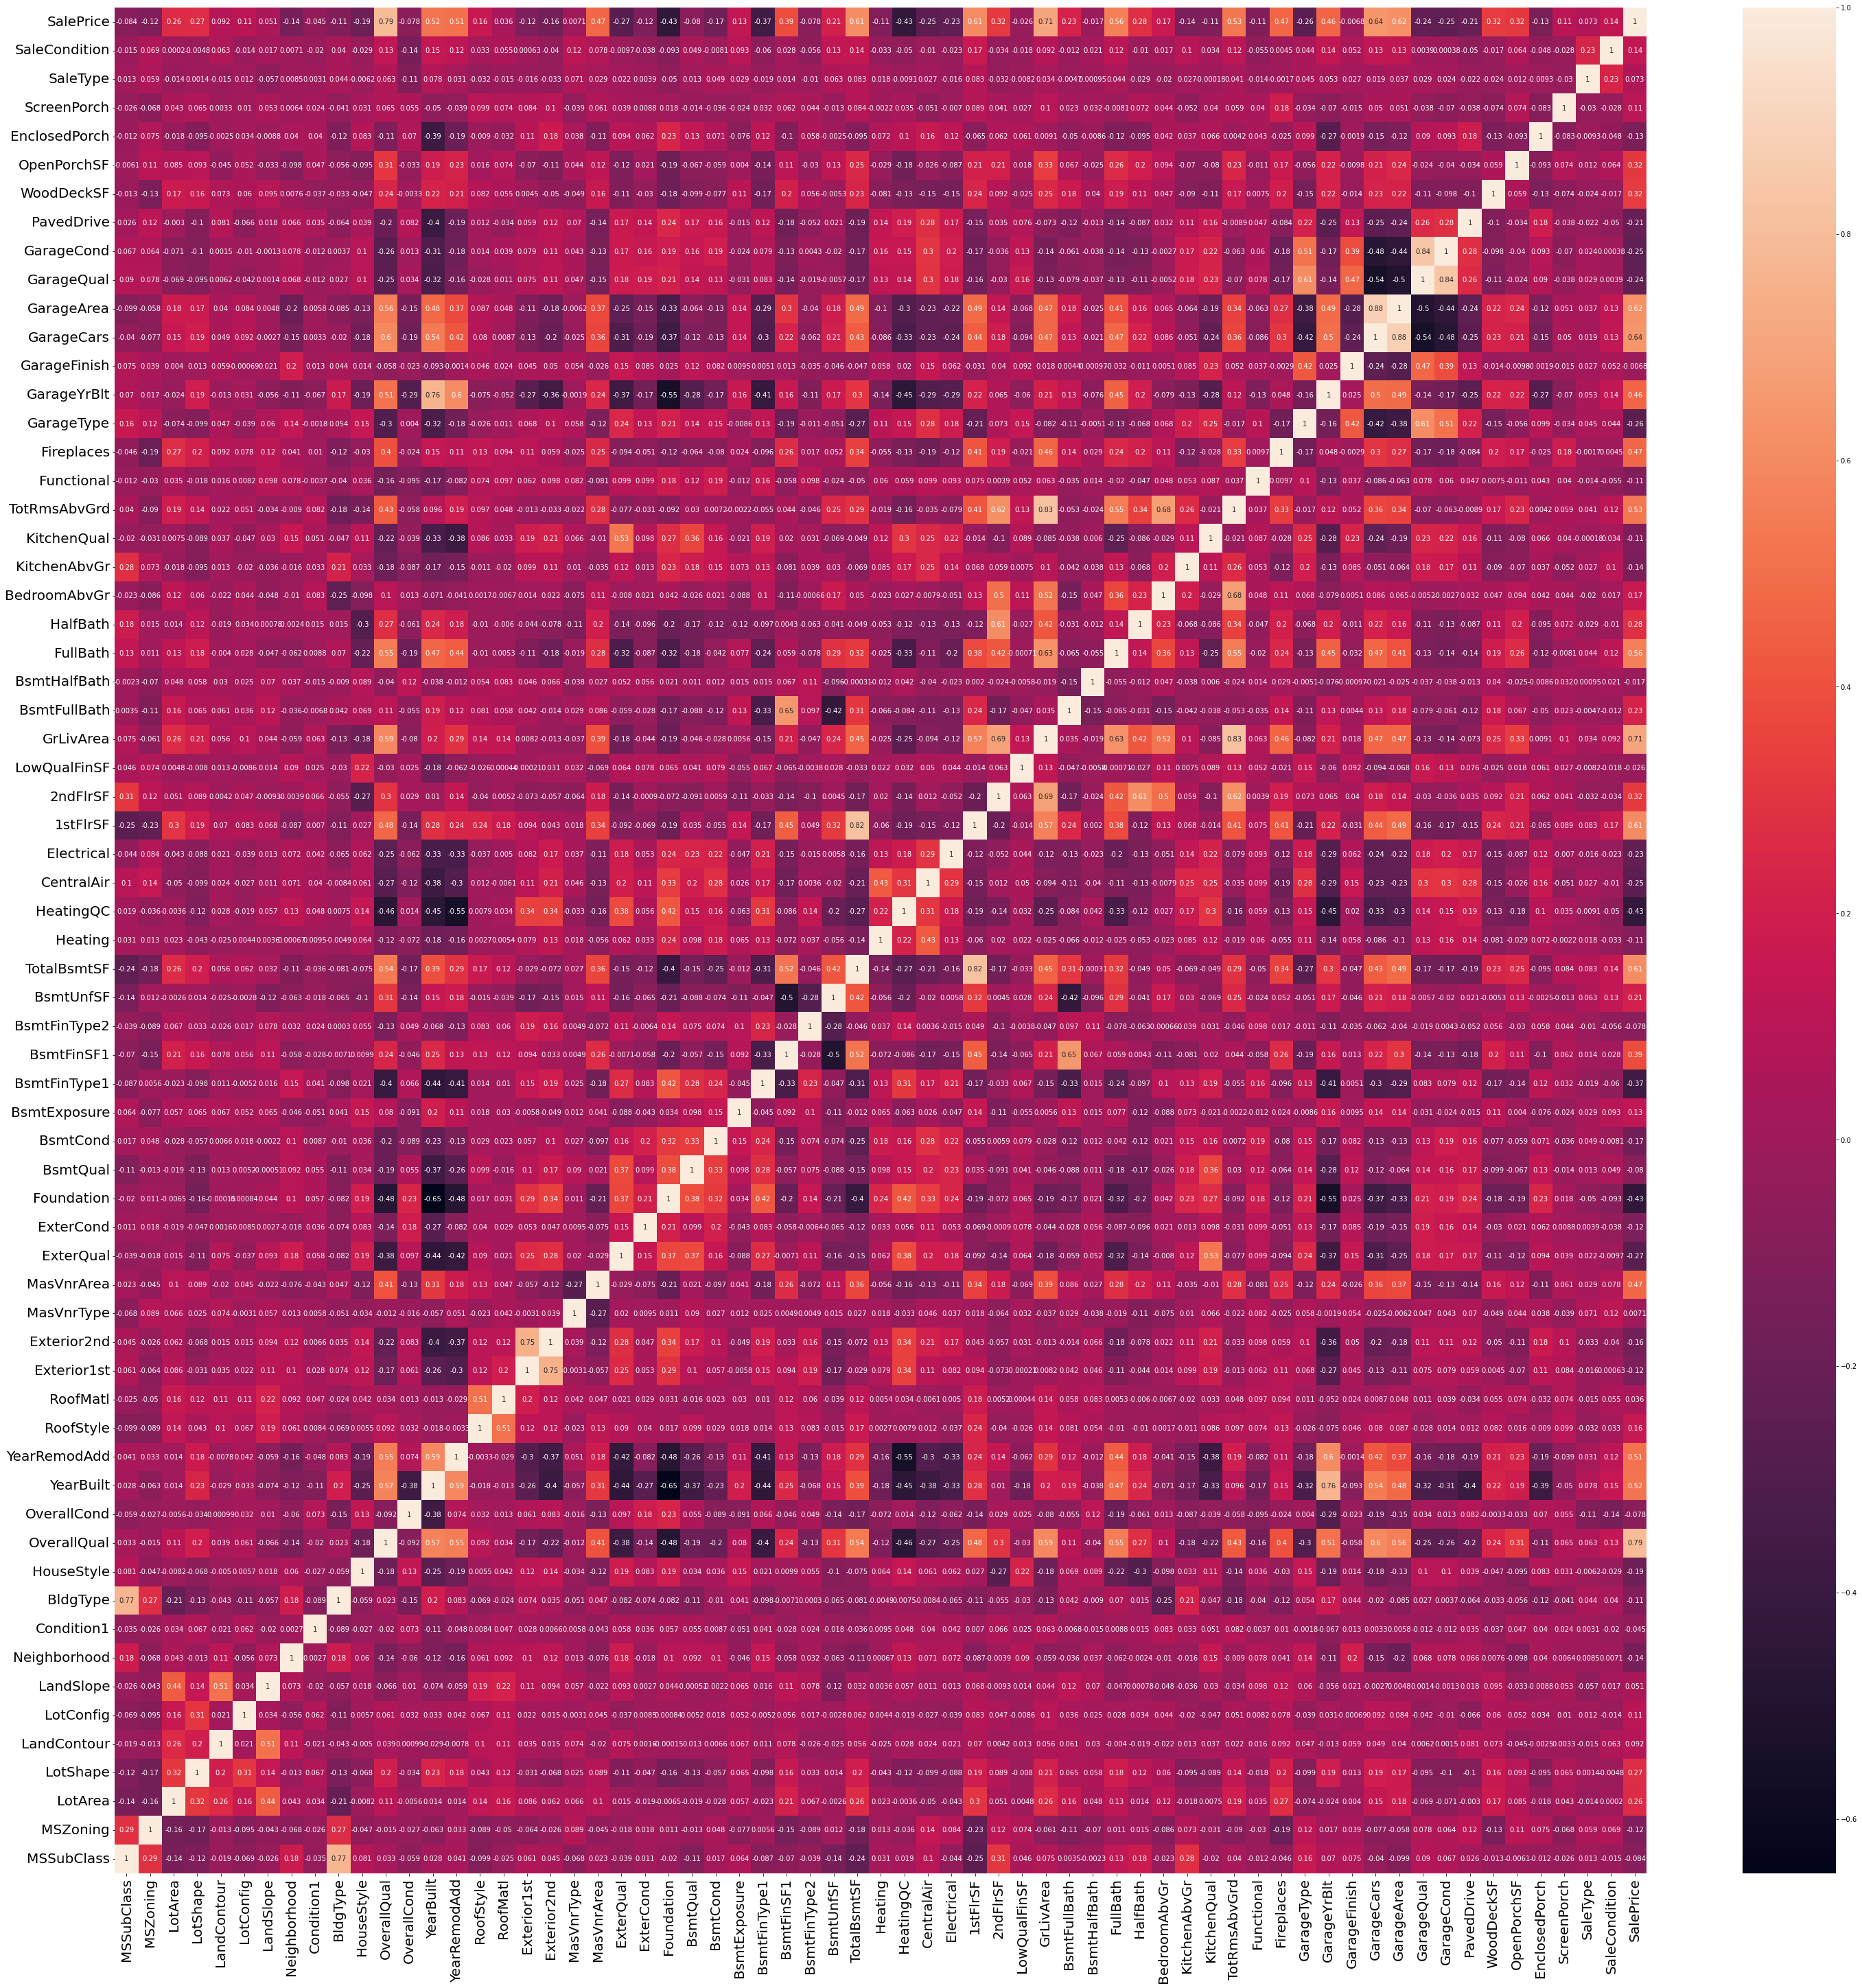

In [119]:
# lets try to find relation between each columns with help of heatmap
# Set the width and height of the figure
plt.figure(figsize=(50,50))
heatmap = sns.heatmap(data=data.corr(), annot=True)
heatmap.invert_yaxis()
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),
                       fontsize = 20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),
                       fontsize = 20)
plt.show()

Heatmap give overall idea of full data

For more specificaly we can list for each columns

Its very difficult for me to find corretion between columns due to its size

So Iam going to can find corretaion for OverallQual column

So that I can easly find more correlated columns

From the heatmap we can easly observe that 2 columns is more related with OverallQual, So I going to print that columns.

In [120]:
# find more correlation with OverallQual
pd.DataFrame(data.corr().loc['OverallCond'].abs().sort_values(ascending=False)).head(3)

,OverallCond
OverallCond,1.000000
YearBuilt,0.375983
GarageYrBlt,0.290422


#### Cluster between OverallQual and YearBuilt

In [121]:
cluster_cols(data, 'OverallQual', 'YearBuilt', 7, 'Cluster4')

,OverallQual,YearBuilt,Cluster4
Id,,,
1,7,2003,3
2,6,1976,4
3,7,2001,3
4,7,1915,2
5,8,2000,0


In [122]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13771351896964534

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.1377135189696** from **0.13818376**

Lets try to visualize this clustering.

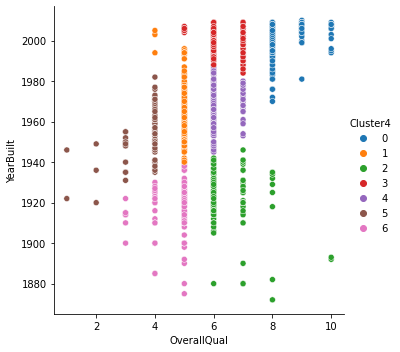

In [123]:
# Visualize this clustering using relational plot
sns.relplot(x='OverallQual', y='YearBuilt',
           hue='Cluster4', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster4'>

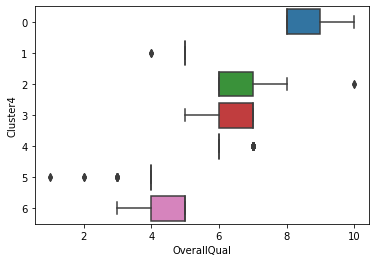

In [124]:
# box-plot
sns.boxplot(x='OverallQual', y='Cluster4',
           data=data)

#### Cluster between OverallQual and GarageYrBlt

In [125]:
cluster_cols(data, 'OverallQual', 'GarageYrBlt', 3, 'Cluster5')

,OverallQual,GarageYrBlt,Cluster5
Id,,,
1,7,2003.0,1
2,6,1976.0,0
3,7,2001.0,1
4,7,1998.0,1
5,8,2000.0,1


In [126]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.1372744133707872

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.1372744133707872** from **0.1377135189696**

Lets try to visualize this clustering.

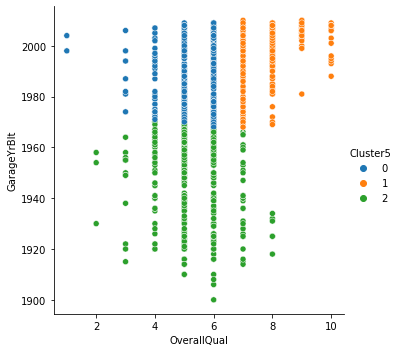

In [127]:
# Visualize this clustering using relational plot
sns.relplot(x='OverallQual', y='GarageYrBlt',
           hue='Cluster5', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster5'>

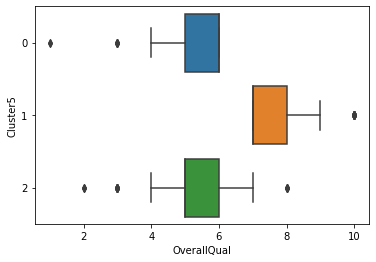

In [128]:
# box-plot
sns.boxplot(x='OverallQual', y='Cluster5',
           data=data)

Cluster columns high MI-Score, 
**Heatmap** help to find more correlated columns
#### Cluster - TotalBsmtSF Vs. 1stFlrSF

In [129]:
# find more correlation with TotalBsmtSF
pd.DataFrame(data.corr().loc['TotalBsmtSF'].abs().sort_values(ascending=False)).head(3)

,TotalBsmtSF
TotalBsmtSF,1.000000
1stFlrSF,0.819530
SalePrice,0.613581


In [130]:
cluster_cols(data, 'TotalBsmtSF', '1stFlrSF', 6, 'Cluster6')

,TotalBsmtSF,1stFlrSF,Cluster6
Id,,,
1,856,856,3
2,1262,1262,0
3,920,920,3
4,756,961,3
5,1145,1145,0


In [131]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13721136881065293

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.13721136881065293** from **0.1372744133707872**

Lets try to visualize this clustering.

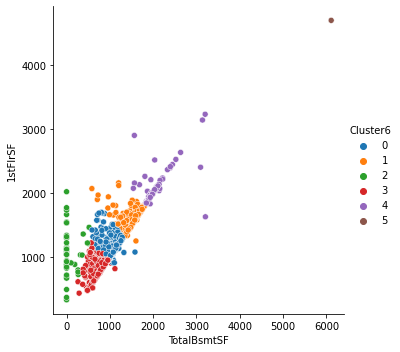

In [132]:
# Visualize this clustering using relational plot
sns.relplot(x='TotalBsmtSF', y='1stFlrSF',
           hue='Cluster6', data=data)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='Cluster6'>

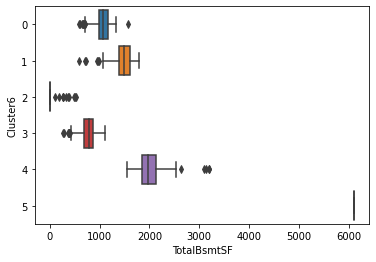

In [133]:
# box-plot
sns.boxplot(x='TotalBsmtSF', y='Cluster6',
           data=data)

#### Cluster - FullBath Vs. GrLivArea

In [134]:
# find more correlation with FullBath
pd.DataFrame(data.corr().loc['FullBath'].abs().sort_values(ascending=False)).head(3)

,FullBath
FullBath,1.000000
GrLivArea,0.630012
SalePrice,0.560664


In [135]:
cluster_cols(data, 'FullBath', 'GrLivArea', 6, 'Cluster7')

,FullBath,GrLivArea,Cluster7
Id,,,
1,2,1710,1
2,2,1262,5
3,2,1786,1
4,1,1717,3
5,2,2198,2


In [136]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.1371932180250347

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.1371932180250347** from **0.13721136881065293**

Lets try to visualize this clustering.

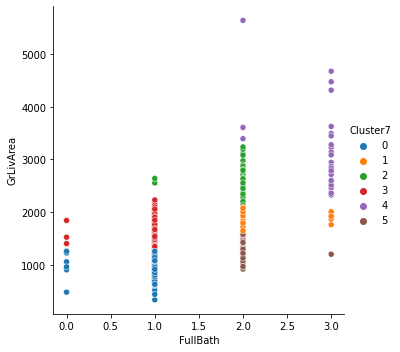

In [137]:
# Visualize this clustering using relational plot
sns.relplot(x='FullBath', y='GrLivArea',
           hue='Cluster7', data=data)

<AxesSubplot:xlabel='FullBath', ylabel='Cluster7'>

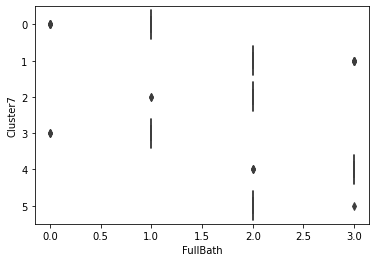

In [138]:
# box-plot
sns.boxplot(x='FullBath', y='Cluster7',
           data=data)

#### Cluster - GarageType Vs. GarageQual

In [139]:
# find more correlation with GarageType
pd.DataFrame(data.corr().loc['GarageType'].abs().sort_values(ascending=False)).head(3)

,GarageType
GarageType,1.000000
GarageQual,0.613010
GarageCond,0.509335


In [140]:
cluster_cols(data, 'GarageType', 'GarageQual', 4, 'Cluster8')

,GarageType,GarageQual,Cluster8
Id,,,
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,2
5,0,0,0


In [141]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13718883888296823

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.13718883888296823** from **0.1371932180250347**

Lets try to visualize this clustering.

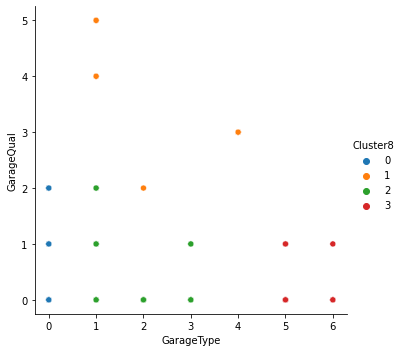

In [142]:
# Visualize this clustering using relational plot
sns.relplot(x='GarageType', y='GarageQual',
           hue='Cluster8', data=data)

<AxesSubplot:xlabel='GarageType', ylabel='Cluster8'>

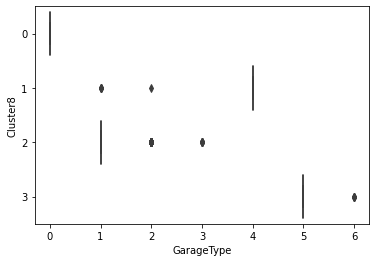

In [143]:
# box-plot
sns.boxplot(x='GarageType', y='Cluster8',
           data=data)

#### Cluster - GarageType Vs. GarageCond

In [144]:
cluster_cols(data, 'GarageType', 'GarageCond', 4, 'Cluster9')

,GarageType,GarageCond,Cluster9
Id,,,
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,2
5,0,0,1


In [145]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13699674876034657

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.13699674876034657** from **0.13718883888296823**

Lets try to visualize this clustering.

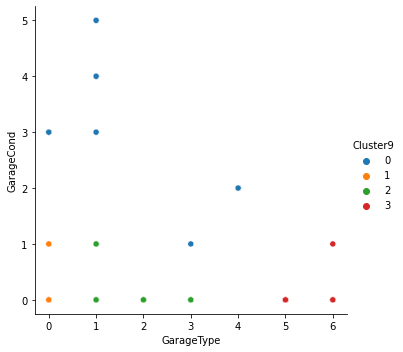

In [146]:
# Visualize this clustering using relational plot
sns.relplot(x='GarageType', y='GarageCond',
           hue='Cluster9', data=data)

<AxesSubplot:xlabel='GarageType', ylabel='Cluster9'>

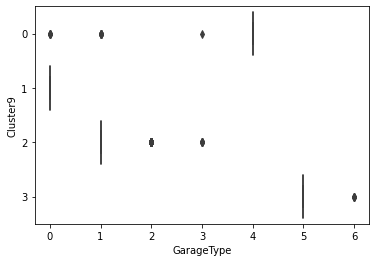

In [147]:
# box-plot
sns.boxplot(x='GarageType', y='Cluster9',
           data=data)

#### Cluster - Foundation Vs. YearBuilt

In [148]:
# find more correlation with Foundation
pd.DataFrame(data.corr().loc['Foundation'].abs().sort_values(ascending=False)).head(3)

,Foundation
Foundation,1.000000
YearBuilt,0.647865
GarageYrBlt,0.551101


In [149]:
cluster_cols(data, 'Foundation', 'YearBuilt', 9, 'Cluster10')

,Foundation,YearBuilt,Cluster10
Id,,,
1,0,2003,1
2,1,1976,5
3,0,2001,1
4,2,1915,2
5,0,2000,1


In [150]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13664753713771674

Cluster between **High-Low** MI-Score columns.
Error get reduced to **0.13664753713771674** from **0.13699674876034657**

Lets try to visualize this clustering.

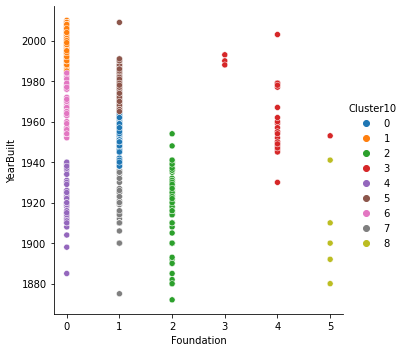

In [151]:
# Visualize this clustering using relational plot
sns.relplot(x='Foundation', y='YearBuilt',
           hue='Cluster10', data=data)

<AxesSubplot:xlabel='Foundation', ylabel='Cluster10'>

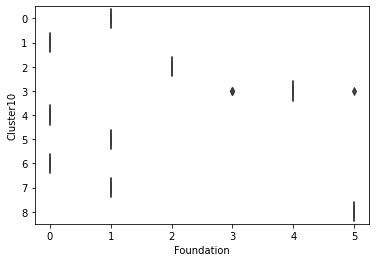

In [152]:
# box-plot
sns.boxplot(x='Foundation', y='Cluster10',
           data=data)

## 3. Principal Component Analysis (PCA)
**PCA** basically gives you direct access to the correlational structure of your data.
**PCA** also tells us the amount of variation in each component.

Idea of **PCA**: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

We going to select high **MI-Score** columns

In [153]:
features = ['OverallQual', 'Neighborhood',
            'GarageArea', 'GrLivArea']

In [154]:
x = data.copy()
y = x.pop('SalePrice')
x = x.loc[:, features]

# standardize
x_scaled = (x - x.mean(axis=0)) / x.std(axis=0)

In [155]:
from sklearn.decomposition import PCA

# create pca
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

# convert to dataframe
component_names = [f'PC{i+1}' for i in range(x_pca.shape[1])]
x_pca = pd.DataFrame(x_pca,
                    columns=component_names)
x_pca.head()

,PC1,PC2,PC3,PC4
0,1.103842,-1.396683,-0.350091,-0.168963
1,-0.055212,-1.521754,-0.051141,-0.170917
2,1.339615,-1.371017,-0.222988,-0.003834
3,1.288121,-1.083766,0.049212,-0.029229
4,2.689931,-0.635309,0.162569,0.156049


In [156]:
loadings = pd.DataFrame(pca.components_.T,       # transpose the matrix of loadings
                       columns=component_names,  # columns are pca
                       index=x.columns           # rows - original features
                       )
loadings

,PC1,PC2,PC3,PC4
OverallQual,0.590062,0.117875,-0.086842,-0.793971
Neighborhood,-0.197372,0.957574,0.208212,-0.027292
GarageArea,0.556256,-0.042309,0.764279,0.323522
GrLivArea,0.550863,0.259554,-0.604138,0.514003


#### Function - plot Explained variance

In [157]:
# function - plot Explained variance
def plot_variance(pca, width=8, dpi=100):
    # create figure
    fig, axis = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n+1)
    # explained variance
    evar = pca.explained_variance_ratio_
    axis[0].bar(grid, evar)
    axis[0].set(xlabel='Component',
               title='% Explained Variance',
               ylim=(0.0, 1.0))
    # cumulative variance
    cvar = np.cumsum(evar)
    axis[1].plot(np.r_[0, grid],
                np.r_[0, cvar], 'o-')
    axis[1].set(xlabel='Component',
               title='% Cumulative Variance',
               ylim=(0.0, 1.0))
    # set figure
    fig.set(figwidth=width, dpi=dpi)
    return axis

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

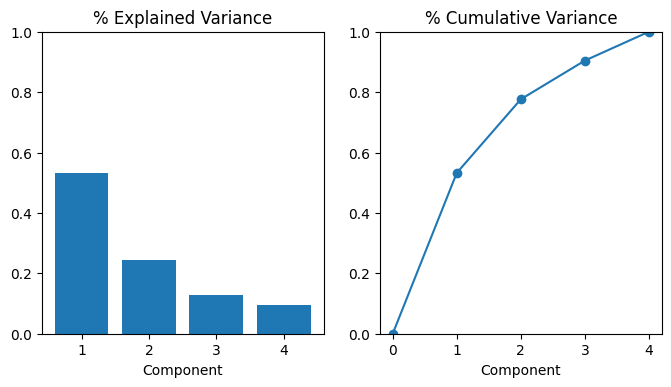

In [158]:
# plot explained variance
plot_variance(pca)

In [159]:
# Take a look mi-score
mi_scores = make_mi_score(x_pca, y,
                          discrete_features=False)
mi_scores

PC1    0.787652
PC2    0.270967
PC3    0.041561
PC4    0.024731
Name: MI Score, dtype: float64

In [160]:
x_pca.head()

,PC1,PC2,PC3,PC4
0,1.103842,-1.396683,-0.350091,-0.168963
1,-0.055212,-1.521754,-0.051141,-0.170917
2,1.339615,-1.371017,-0.222988,-0.003834
3,1.288121,-1.083766,0.049212,-0.029229
4,2.689931,-0.635309,0.162569,0.156049


**PC1** have high **MI-Score**

Lets check error score after **PCA** columns added to our dataset

In [161]:
x = data.copy()
y = x.pop('SalePrice')

# lets add PC1 to dataset
x = x.join(x_pca)

# error score
score_dataset(x, y)

0.139344178064264

Score increases from **0.13664753713771674** to **0.13910495252411925**

Let's try with cluster between **PCA** columns

In [162]:
# cluster between PCA columns
cluster_cols(x_pca, 'PC1', 'PC4', 8, 'PCluster')

,PC1,PC4,PCluster
0,1.103842,-0.168963,1
1,-0.055212,-0.170917,4
2,1.339615,-0.003834,1
3,1.288121,-0.029229,1
4,2.689931,0.156049,5


In [163]:
x = data.copy()
y = x.pop('SalePrice')

# lets add PCluster to dataset
x = x.join(x_pca.PCluster)

# error score
score_dataset(x, y)

0.13817633614861424

When cluster with **PCA** columns, Error score is **NOT** reducing

So removing cluster column from **PCA**.

In [164]:
x_pca = x_pca.drop('PCluster', axis=1)
x_pca.head()

,PC1,PC2,PC3,PC4
0,1.103842,-1.396683,-0.350091,-0.168963
1,-0.055212,-1.521754,-0.051141,-0.170917
2,1.339615,-1.371017,-0.222988,-0.003834
3,1.288121,-1.083766,0.049212,-0.029229
4,2.689931,-0.635309,0.162569,0.156049


#### Lets try with high correlation with SalePrice columns

In [165]:
pd.DataFrame(data.corrwith(data.SalePrice).sort_values(ascending=False)).head(5)

,0
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431


In [166]:
features = ['OverallQual', 'GrLivArea',
            'GarageCars', 'GarageArea']

In [167]:
x = data.copy()
y = x.pop('SalePrice')
x = x.loc[:, features]

# standardize
x_scaled = (x - x.mean(axis=0)) / x.std(axis=0)

In [168]:
# create pca
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

# convert to dataframe
component_names = [f'PC{i+1}' for i in range(x_pca.shape[1])]
x_pca = pd.DataFrame(x_pca,
                    columns=component_names)
x_pca.head()

,PC1,PC2,PC3,PC4
0,0.833854,0.188642,-0.218418,0.052967
1,-0.111497,-0.467656,-0.206665,-0.254485
2,1.045963,0.161159,-0.082657,0.241366
3,1.790786,-0.584019,-0.030570,-0.607364
4,3.026383,-0.110065,0.087726,0.039700


In [169]:
loadings = pd.DataFrame(pca.components_.T,       # transpose the matrix of loadings
                       columns=component_names,  # columns are pca
                       index=x.columns           # rows - original features
                       )
loadings

,PC1,PC2,PC3,PC4
OverallQual,0.488896,0.348497,-0.796257,0.074198
GrLivArea,0.438381,0.694250,0.569739,-0.035157
GarageCars,0.536661,-0.434597,0.072237,-0.719655
GarageArea,0.529903,-0.455732,0.190143,0.689461


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

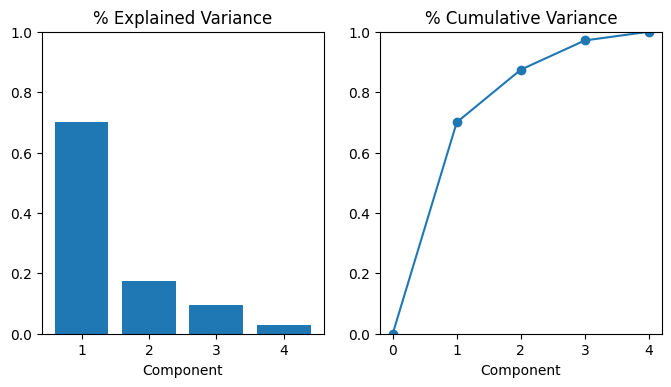

In [170]:
# plot explained variance
plot_variance(pca)

In [171]:
# Take a look mi-score
mi_scores = make_mi_score(x_pca, y,
                          discrete_features=False)
mi_scores

PC1    0.753198
PC2    0.139690
PC4    0.113638
PC3    0.021365
Name: MI Score, dtype: float64

In [172]:
x = data.copy()
y = x.pop('SalePrice')

# lets add PC1 to dataset
x = x.join(x_pca)

# error score
score_dataset(x, y)

0.13920225414513454

#### Still the Error score NOT decreasing
Let's try with clustering **PCA** columns

In [173]:
# cluster between PCA columns
cluster_cols(x_pca, 'PC2', 'PC4', 11, 'PCluster')

,PC2,PC4,PCluster
0,0.188642,0.052967,0
1,-0.467656,-0.254485,4
2,0.161159,0.241366,0
3,-0.584019,-0.607364,10
4,-0.110065,0.039700,0


In [174]:
x = data.copy()
y = x.pop('SalePrice')

# lets add PCluster to dataset
x = x.join(x_pca.PCluster)

# error score
score_dataset(x, y)

0.13655128981647732

In [175]:
# add PCluster to dataset
data = data.join(x_pca.PCluster)

When cluster with **PCA** columns

Error get reduced to **0.13655128981647732** from **0.13664753713771674**

Lets try to visualize this clustering.

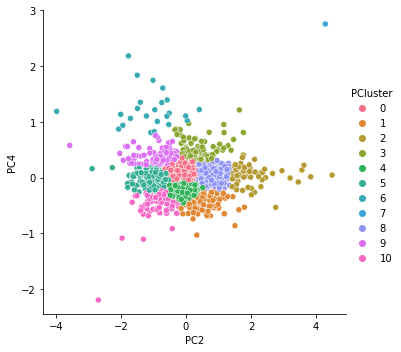

In [176]:
# Visualize this clustering using relational plot
sns.relplot(x='PC2', y='PC4',
           hue='PCluster', data=x_pca)

<AxesSubplot:xlabel='PC2', ylabel='PCluster'>

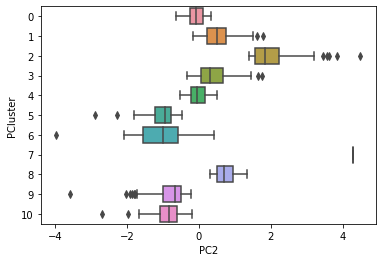

In [177]:
# box-plot
sns.boxplot(x='PC2', y='PCluster',
           data=x_pca)

### 4. New Features
Make new features from high **MI-Score** columns.

In [178]:
x = data.copy()
y = x.pop('SalePrice')

# new features
x["Feature1"] = x.GrLivArea + x.TotalBsmtSF
x["Feature2"] = x.YearRemodAdd * x.TotalBsmtSF
x["Feature3"] = x.OverallQual * x.TotalBsmtSF

# score
score_dataset(x, y)

0.13554077099934525

In [179]:
# Lets add these columns into our dataset
data["Feature1"] = data.GrLivArea + data.TotalBsmtSF
data["Feature2"] = data.YearRemodAdd * data.TotalBsmtSF
data["Feature3"] = data.OverallQual * data.TotalBsmtSF

When we add new features from high **MI-Score** columns

Error get reduced to **0.13554077099934525** from **0.13655128981647732**

### 5. Outlier Detection
We can use **PCA** to detect outliers in the dataset (meaning, data points that are unusually extreme in some way). Outliers can have a detrimental effect on model performance.

Lets show distribution plots for each of the **principal components**.

In [180]:
x_pca.head()

,PC1,PC2,PC3,PC4,PCluster
0,0.833854,0.188642,-0.218418,0.052967,0
1,-0.111497,-0.467656,-0.206665,-0.254485,4
2,1.045963,0.161159,-0.082657,0.241366,0
3,1.790786,-0.584019,-0.030570,-0.607364,10
4,3.026383,-0.110065,0.087726,0.039700,0


In [181]:
# remove PCluster column
x_pca = x_pca.drop('PCluster', axis=1)
x_pca.head()

,PC1,PC2,PC3,PC4
0,0.833854,0.188642,-0.218418,0.052967
1,-0.111497,-0.467656,-0.206665,-0.254485
2,1.045963,0.161159,-0.082657,0.241366
3,1.790786,-0.584019,-0.030570,-0.607364
4,3.026383,-0.110065,0.087726,0.039700


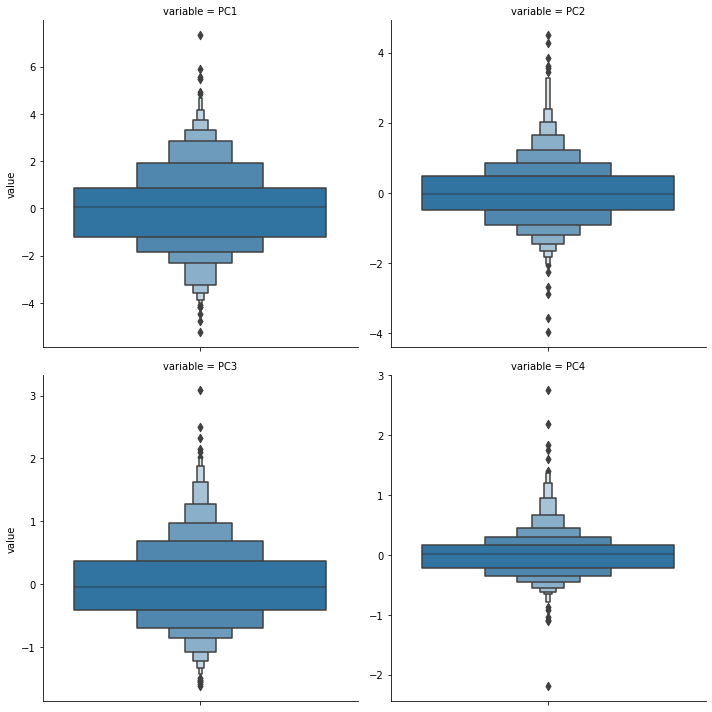

In [182]:
# distribution plot
sns.catplot(y='value', col='variable',
           data=x_pca.melt(), kind='boxen',
           sharey=False, col_wrap=2)

In each of the components there are several points lying at the extreme ends of the distributions - **outliers**

Find the extreme points

Extreme points in the **PC1**:

In [183]:
idx = x_pca['PC1'].sort_values(ascending=False).index
data.iloc[idx].head(4)

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,...,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9,Cluster10,PCluster,Feature1,Feature2,Feature3
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,0,63887,3,1,2,0,15,1,0,...,1,5,4,0,1,1,0,11752,12268880,61100
524,60,0,40094,1,1,0,0,15,2,0,...,1,4,4,2,2,1,0,7814,6301104,31380
1183,60,0,15623,1,0,2,0,3,0,0,...,1,4,4,0,1,1,9,6872,4782416,23960
692,60,0,21535,1,0,2,0,3,0,0,...,1,4,4,0,1,1,8,6760,4875780,24440


From the distribution plot of **PC1** we can clearly see that, there are **3 outliers**

So lets remove that outliers

In [184]:
x = data.copy()

# let drop outliers
x = x.drop(1299)
x = x.drop(524)
x = x.drop(1183)

y = x.pop('SalePrice')
score_dataset(x, y)

0.13509226779849576

When we remove outlier from **PC1** column

Error get reduced to **0.13509226779849576** from **0.13554077099934525**

Lets remove these outliers from dataset

In [185]:
# drop outliers from data
data = data.drop(1299)
data = data.drop(524)
data = data.drop(1183)

**What is really these outliers ?**

Lets find out common things related to **outliers**. It will help to dealing with real world data.

I changed all **categorical columns** by using label encoding, I going load data from data file.

In [186]:
# load data
data_copy = pd.read_csv(r'train.csv', index_col='Id')
data_copy.shape

(1460, 80)

**To Display all columns**

In [187]:
pd.set_option('display.max_columns', None)

In [188]:
data_copy.iloc[idx].head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1636,Unf,0,442,2078,GasA,Ex,Y,SBrkr,2084,0,0,2084,1,0,2,0,2,1,Ex,7,Typ,1,Gd,Attchd,2007.0,Fin,3,1220,TA,TA,Y,188,45,0,0,0,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1269,50,RL,NaN,14100,Pave,NaN,IR1,Lvl,AllPub,Inside,Mod,Crawfor,Norm,Norm,1Fam,1.5Fin,8,9,1935,1997,Gable,CompShg,Stucco,Stucco,BrkFace,632.0,TA,Gd,CBlock,TA,TA,Mn,Rec,192,Unf,0,536,728,GasA,Ex,Y,SBrkr,1968,1479,0,3447,0,0,3,1,4,1,Gd,11,Typ,2,Gd,BuiltIn,1982.0,Unf,3,1014,TA,TA,Y,314,12,0,0,0,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,381000
804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933


Notice that there are several dwellings listed as **Partial** sales in the **Edwards neighborhood** that stand out. A **partial sale** is what occurs when there are multiple owners of a property and one or more of them sell their **"partial"** ownership of the property.

These kinds of sales are often happen during the settlement of a family estate or the dissolution of a business and aren't advertised publicly. If you were trying to predict the value of a house on the open market, you would probably be justified in removing sales like these from your dataset -- they are truly **outliers**.

Extreme points in the **PC2, PC3, PC4**:

In [189]:
# idx = x_pca['PC2'].sort_values(ascending=False).index
# data.iloc[idx].head(4)

In [190]:
# idx = x_pca['PC3'].sort_values(ascending=False).index
# data.iloc[idx].head(4)

In [191]:
# idx = x_pca['PC4'].sort_values(ascending=False).index
# data.iloc[idx].head(4)

When I trying to find outliers by PC2, PC3 & PC4,

It showing: **positional indexers are out-of-bounds**

So we already removed outliers
### Feature Engeneering with Train-data Completed
### So we are going to do same procedure for **Test-Data**
## Feature Engeneering - Test Data
### 1. Mutual Information

In [192]:
data_test = data_test.drop(['YrSold', 'MoSold', 'PoolArea',
                            'Utilities', 'Street', 'Condition2',
                            'BsmtFinSF2', '3SsnPorch', 'MiscVal'],
                           axis=1)

### 2. Clustering
Also categorical columns can't cluster with other columns.

So we going to change all categorical columns to number by using Label Encoding

In [193]:
# make all categorical columns to number, it will help to find heatmap and clusters
data_test = data_test.copy()
# label encoding for categoricals
for colname in data_test.select_dtypes('object'):
    data_test[colname], _ = data_test[colname].factorize()

# all discrete features should now have integer dtypes (double-check this before using MI)
discrete_features = data_test.dtypes == int

In [194]:
cluster_cols(data_test, 'OverallQual', 'LowQualFinSF', 6, 'Cluster1')
cluster_cols(data_test, 'OverallQual', 'KitchenAbvGr', 8, 'Cluster2')
cluster_cols(data_test, 'OverallQual', 'HalfBath', 3, 'Cluster3')
cluster_cols(data_test, 'OverallQual', 'YearBuilt', 7, 'Cluster4')
cluster_cols(data_test, 'OverallQual', 'GarageYrBlt', 3, 'Cluster5')
cluster_cols(data_test, 'TotalBsmtSF', '1stFlrSF', 6, 'Cluster6')
cluster_cols(data_test, 'FullBath', 'GrLivArea', 6, 'Cluster7')
cluster_cols(data_test, 'GarageType', 'GarageQual', 4, 'Cluster8')
cluster_cols(data_test, 'GarageType', 'GarageCond', 4, 'Cluster9')
cluster_cols(data_test, 'Foundation', 'YearBuilt', 9, 'Cluster10')

,Foundation,YearBuilt,Cluster10
Id,,,
1461,0,1961,1
1462,0,1958,1
1463,1,1997,0
1464,1,1998,0
1465,1,1992,0


### 3. Principal Component Analysis (PCA)

In [195]:
features = ['OverallQual', 'GrLivArea',
            'GarageCars', 'GarageArea']

x = data_test.copy()
x = x.loc[:, features]

# standardize
x_scaled = (x - x.mean(axis=0)) / x.std(axis=0)

# create pca
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

# convert to dataframe
component_names = [f'PC{i+1}' for i in range(x_pca.shape[1])]
x_pca = pd.DataFrame(x_pca,
                    columns=component_names)
x_pca.head()

,PC1,PC2,PC3,PC4
0,-0.797672,1.237201,0.008323,1.500785
1,-1.096841,-0.515043,-0.346224,0.197737
2,-0.041008,0.206167,0.806021,-0.223059
3,0.238595,-0.027117,0.208137,-0.228980
4,0.695163,0.026619,-1.263621,-0.047644


In [196]:
loadings = pd.DataFrame(pca.components_.T,       # transpose the matrix of loadings
                       columns=component_names,  # columns are pca
                       index=x.columns           # rows - original features
                       )
loadings

,PC1,PC2,PC3,PC4
OverallQual,0.476815,-0.350073,-0.804962,0.046181
GrLivArea,0.442857,-0.696234,0.564911,-0.003490
GarageCars,0.540696,0.424191,0.094478,-0.720267
GarageArea,0.533080,0.461269,0.154872,0.692150


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

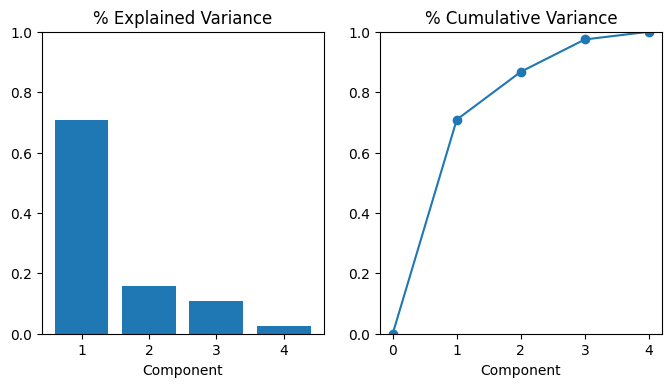

In [197]:
# plot explained variance
plot_variance(pca)

In [198]:
# cluster between PCA columns
cluster_cols(x_pca, 'PC2', 'PC4', 11, 'PCluster')

,PC2,PC4,PCluster
0,1.237201,1.500785,4
1,-0.515043,0.197737,3
2,0.206167,-0.223059,2
3,-0.027117,-0.228980,5
4,0.026619,-0.047644,9


In [199]:
# add PCluster to dataset
data_test = data_test.join(x_pca.PCluster)

### 4. New Features

In [200]:
# Lets add these columns into our test-dataset
data_test["Feature1"] = data_test.GrLivArea + data_test.TotalBsmtSF
data_test["Feature2"] = data_test.YearRemodAdd * data_test.TotalBsmtSF
data_test["Feature3"] = data_test.OverallQual * data_test.TotalBsmtSF

### 5. Outlier Detection

In [201]:
# remove PCluster column
x_pca = x_pca.drop('PCluster', axis=1)
x_pca.head()

,PC1,PC2,PC3,PC4
0,-0.797672,1.237201,0.008323,1.500785
1,-1.096841,-0.515043,-0.346224,0.197737
2,-0.041008,0.206167,0.806021,-0.223059
3,0.238595,-0.027117,0.208137,-0.228980
4,0.695163,0.026619,-1.263621,-0.047644


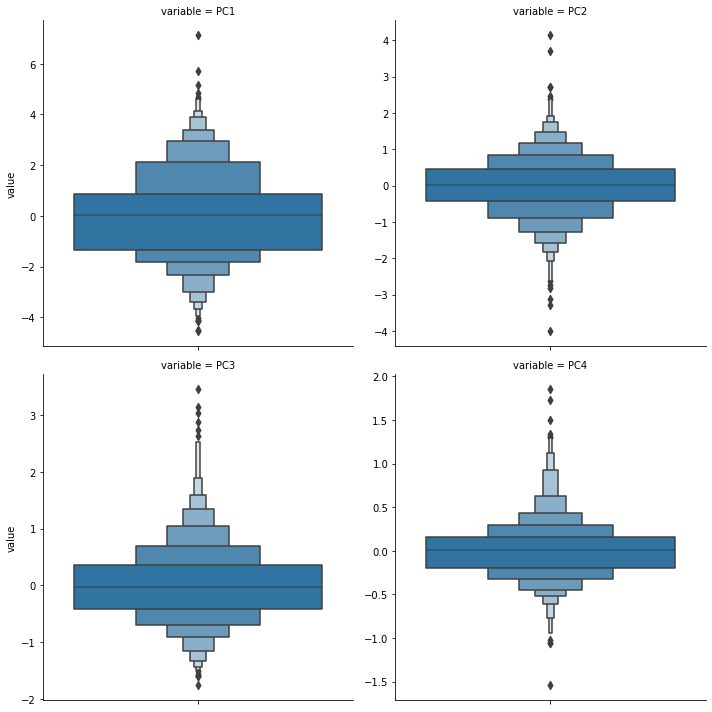

In [202]:
# distribution plot
sns.catplot(y='value', col='variable',
           data=x_pca.melt(), kind='boxen',
           sharey=False, col_wrap=2)

In [203]:
idx = x_pca['PC1'].sort_values(ascending=False).index
data_test.iloc[idx].head(4)

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9,Cluster10,PCluster,Feature1,Feature2,Feature3
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2550,20,1,39290,1,2,0,0,16,1,0,0,10,5,2008,2009,1,0,5,6,2,1224.0,2,0,1,2,0,1,2,4010.0,1,1085.0,5095.0,0,2,0,0,5095,0,0,5095,1.0,1.0,2,1,2,1,2,15,0,2,0,2008.0,1,3.0,1154.0,0,0,0,546,484,0,0,2,1,3,6,1,4,0,4,2,1,2,0,NaN,10190.0,10235855.0,50950.0
1971,60,1,12539,0,0,0,0,5,2,0,1,10,5,2005,2006,1,0,5,6,1,468.0,2,0,1,2,0,1,2,1082.0,1,538.0,1620.0,0,2,0,0,1632,1158,0,2790,1.0,0.0,2,1,4,1,2,10,0,1,2,2005.0,1,4.0,1150.0,0,0,0,30,200,0,192,0,0,3,6,1,4,0,0,2,0,0,0,NaN,4410.0,3249720.0,16200.0
1956,60,1,12511,1,0,1,0,11,1,0,1,7,7,1978,1978,4,2,3,3,1,168.0,1,0,1,1,0,0,1,988.0,1,432.0,1420.0,0,2,0,0,1420,1420,0,2840,0.0,1.0,2,1,4,1,1,8,1,2,0,1978.0,1,4.0,1314.0,0,3,0,0,16,0,208,0,0,1,4,1,3,0,0,2,1,3,8,NaN,4260.0,2808760.0,9940.0
2683,60,1,17242,1,0,0,0,7,1,0,1,9,5,1993,1994,1,0,4,4,1,738.0,1,1,1,2,0,1,0,292.0,4,48.0,1733.0,0,2,0,0,1933,1567,0,3500,1.0,0.0,3,1,4,1,2,11,0,1,0,1993.0,2,3.0,959.0,0,0,0,870,86,0,210,0,0,3,6,1,4,0,5,5,1,2,0,NaN,5233.0,3455602.0,15597.0


In [204]:
# drop outliers from data
data_test = data_test.drop(2550)
data_test = data_test.drop(1971)
data_test = data_test.drop(1956)

### Feature Engeneering Completed for Test-data

## Machine Learning Model

In [205]:
# setting parameters
x = data.copy()
y = x.pop('SalePrice')

# train test data split
from sklearn.model_selection import train_test_split
xgboost = XGBRegressor(n_estimators=500, learning_rate=0.05,
                      n_jobs=4)
for colname in x.select_dtypes(['object', 'category']):
    x[colname], _ = x[colname].factorize()
x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0)
# model
xgboost.fit(x_train, y_train)
# predict
predict_price = xgboost.predict(x_valid)

In [206]:
# Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(predict_price, y_valid)
print('Mean Absolute Error : ' + str(mae))

Mean Absolute Error : 15116.296580693494


In [207]:
# Mean Squared Log Error (MSLE)
from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(predict_price, y_valid)
print('Mean Squared Log Error : ' + str(msle))

Mean Squared Log Error : 0.014121526523353281


In [209]:
# Error Score
score_dataset(x, y, model=xgboost)

0.1257166376051974

### We created a Machine Learning Model